## Anomaly Detection

Anomaly detection (also outlier detection) is the identification of items, events or observations which do not conform to an expected pattern or other items in a dataset

Applicable in both the supervised and unsupervised settings. For the purpose of this presentation we use the creditcard dataset from Kaggle.  

In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score,confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

In [2]:
# Load datasets
current_path = os.getcwd()
file = '\\datasets\\credit_card_data\\creditcard.csv'
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

## Let's understand the data a little bit

In [3]:
print(dataX.shape)
dataX.head(10)

(284807, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68


## Let's Analyze the distribution of data 

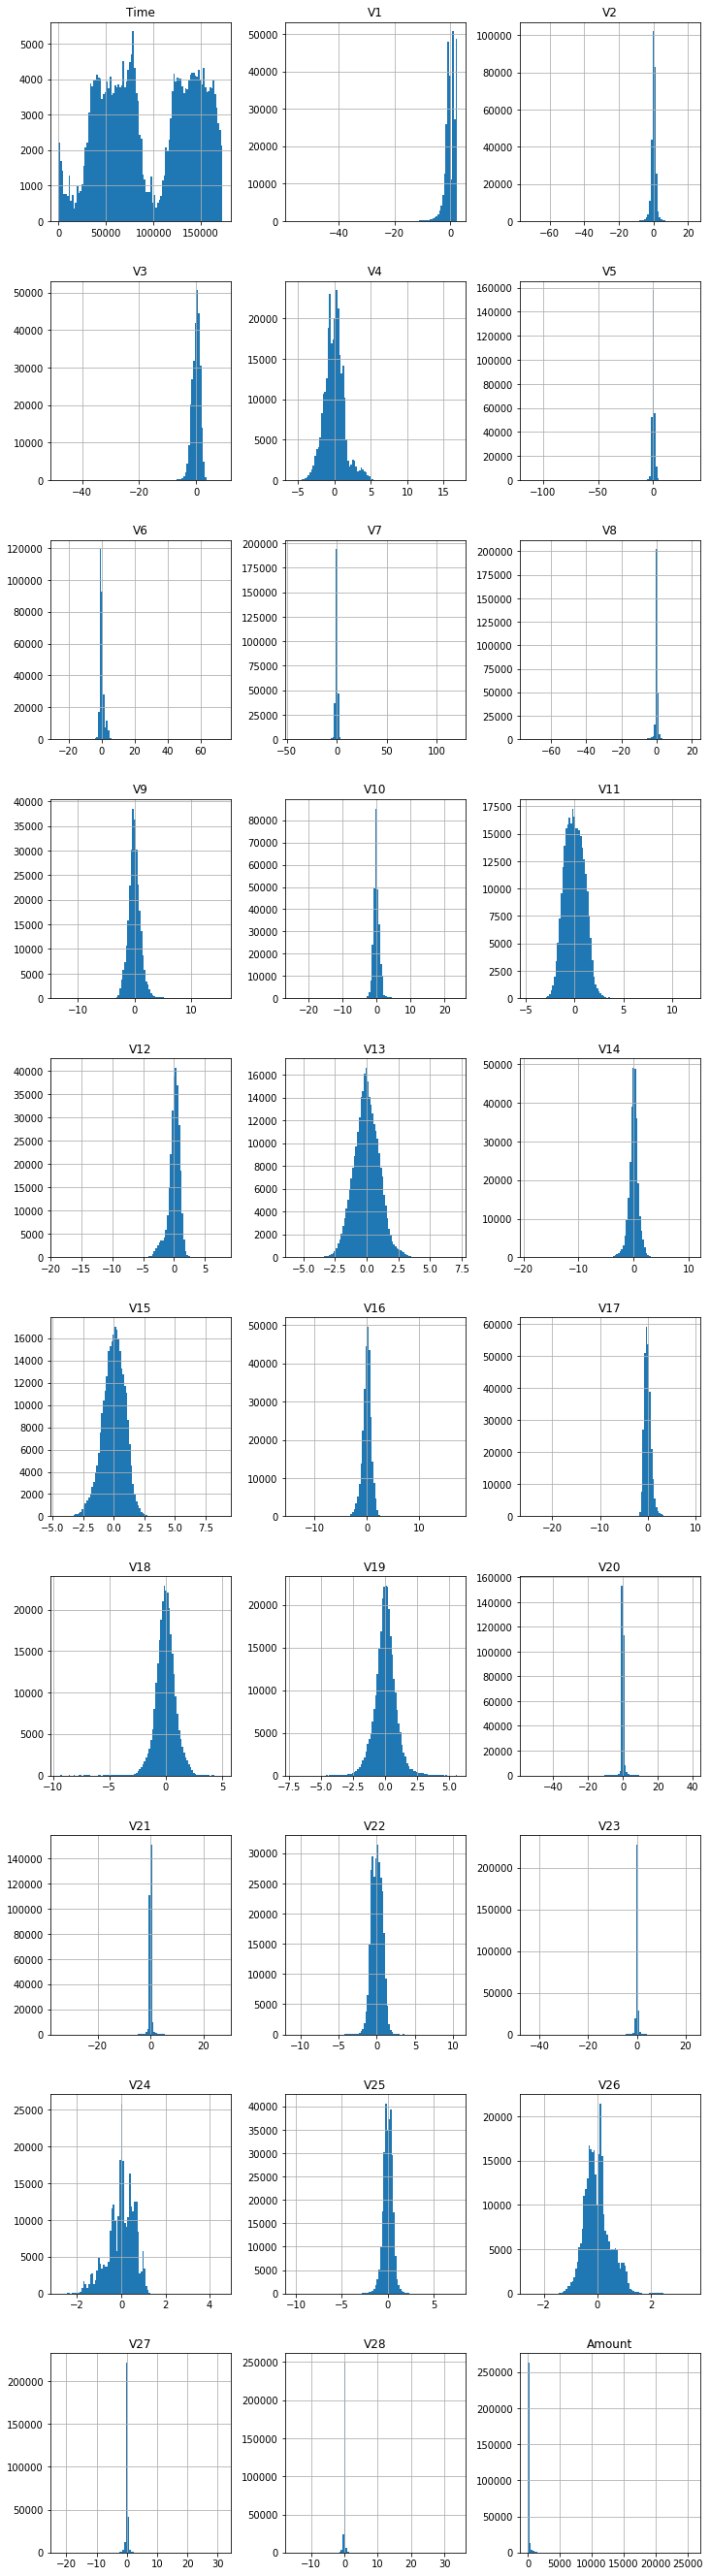

In [4]:
fig, axes = plt.subplots(len(dataX.columns)//3, 3, figsize=(12, 48))
rowCount = 0
colCount = 0
for col in dataX.columns:
    dataX.hist(column = col, bins = 100, ax=axes[rowCount][colCount])
    if colCount >=2:
        rowCount = rowCount +1 
        colCount = 0
    else:
        colCount = colCount+1

## Data Pre-processing - Scaling

Standard Scalar will scale them to zero mean and 1 standard deviation.

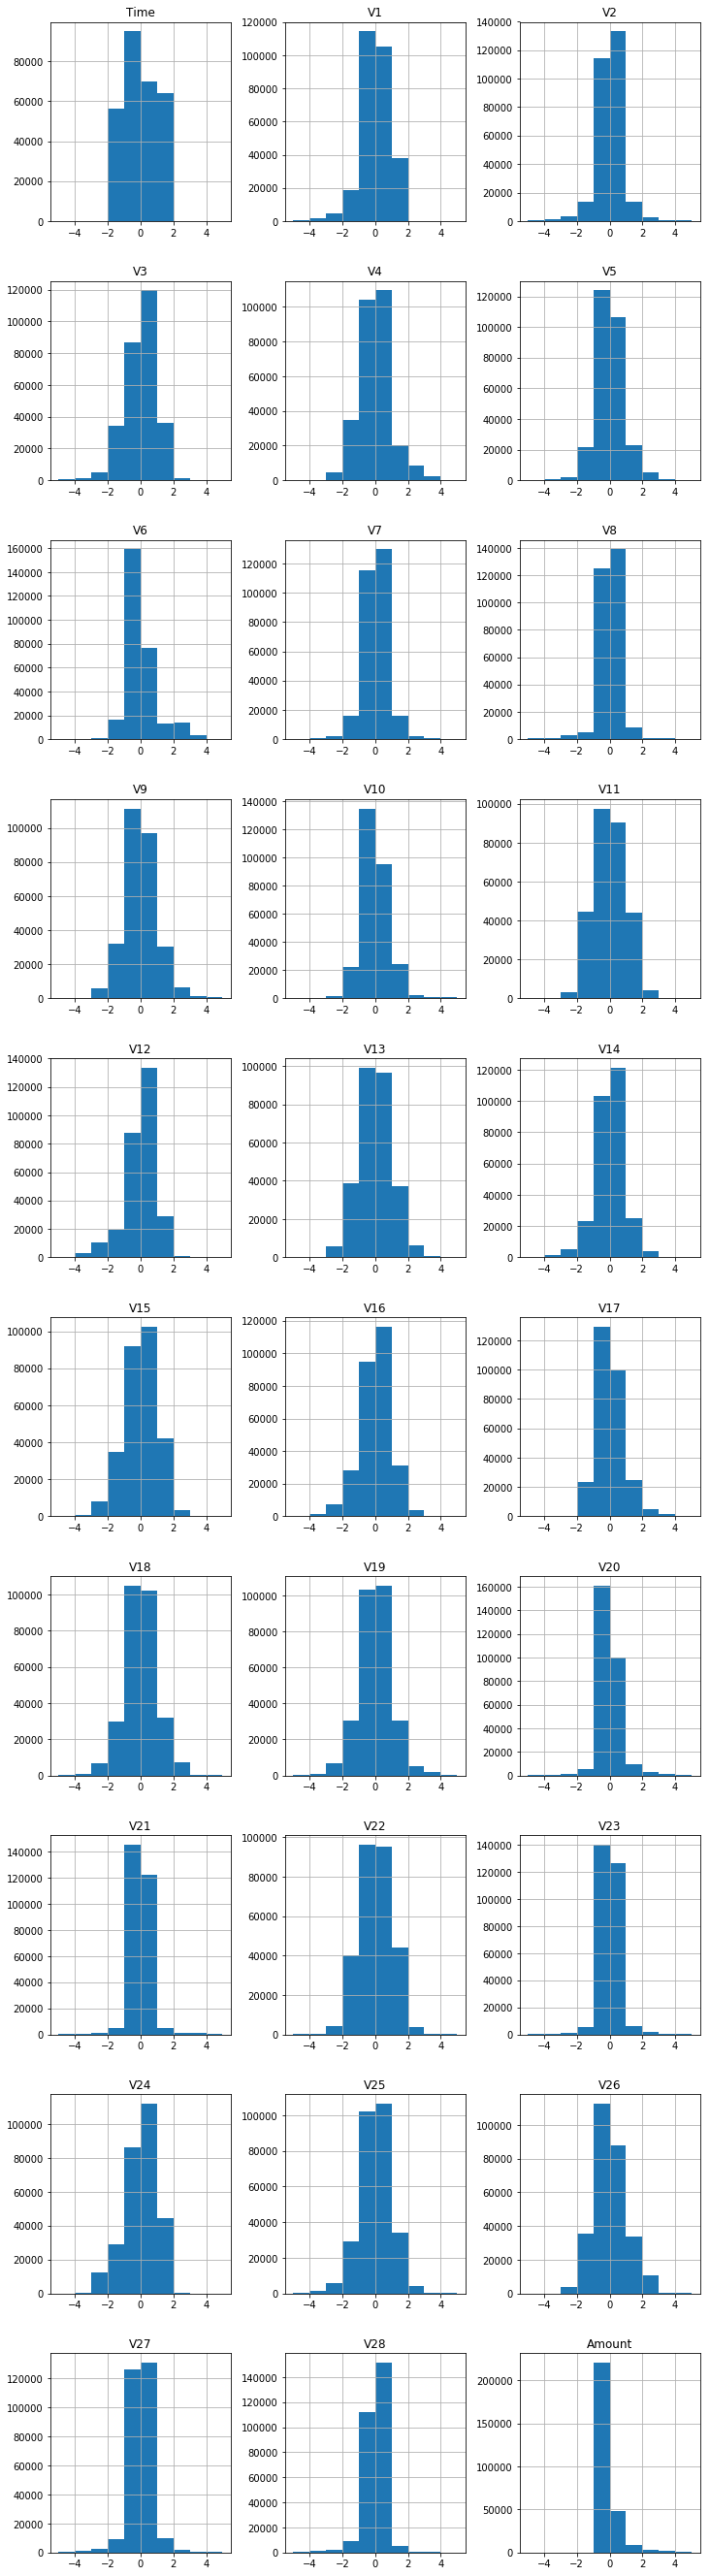

In [5]:
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

fig, axes = plt.subplots(len(dataX.columns)//3, 3, figsize=(12, 48))
rowCount = 0
colCount = 0
for col in dataX.columns:
    dataX.hist(column = col, ax=axes[rowCount][colCount],range=[-5, 5])
    if colCount >=2:
        rowCount = rowCount +1 
        colCount = 0
    else:
        colCount = colCount+1

In [6]:
dataX.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.050379e-14,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,...,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.996583e+00,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,-8.552120e-01,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,-2.131453e-01,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,9.372174e-01,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,1.642058e+00,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


## Helper Methods

In [7]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds
    
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)
    



## Let's start with a simple distance based technique for identifying the outliers

### Distance Based Methods

#### Univariate Models

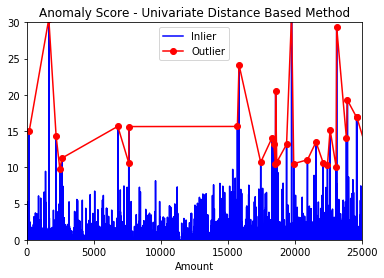

In [8]:
import pandas as pd

def get_outliers_by_IQR(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    min_value = q1 - (iqr*1.5)
    max_value = q3 + (iqr*1.5)
    outliers = (data < min_value) | (data > max_value)
    return data.loc[outliers]

def get_outliers_by_median(data):
    median = data.median()
    min_value = median - 10
    max_value = median + 10
    outliers = (data < min_value) | (data > max_value)
    return data.loc[outliers]

data_Amount= dataX['Amount']

outlierDF = pd.DataFrame(data_Amount)
outlierDF['isOutlierIQR'] = 0
outlierDF['isOutlierMED'] = 0

#Method 1: 

outlierDF.loc[get_outliers_by_IQR(data_Amount).index,'isOutlierIQR'] = 1

#Method 2: 
outlierDF.loc[get_outliers_by_median(data_Amount).index,'isOutlierMED'] = 1

#Plotting the points

plt.figure()
plt.plot(outlierDF['Amount'].values,color='blue',label='Inlier')
plt.axis([0, 25000, -10, 3])
plt.plot(outlierDF.loc[outlierDF['isOutlierMED'] == 1,'Amount'],color='red',marker='o',label='Outlier')
plt.axis([0, 25000, 0, 30])
plt.title('Anomaly Score - Univariate Distance Based Method')
plt.xlabel('Amount')
plt.legend()
plt.show()

## Multivariate Gaussian Models

In [9]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

## Plotting the first 1000 data points and the outliers among them

In [10]:
mu, sigma = estimateGaussian(dataX[['V1','V21']])
p = multivariateGaussian(dataX[['V1','V21']],mu,sigma)
fscore, ep = selectThresholdByCV(p,dataY)



C:\Program Files\Anaconda3\envs\unsupervisedLearning\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


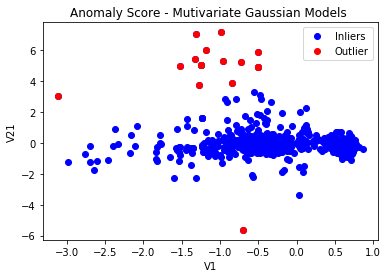

In [11]:
outliers = np.asarray(np.where(p < ep))[0]
outliers = outliers[outliers<1001]
plt.figure() 
plt.xlabel("V1") 
plt.ylabel("V21") 
plt.plot(dataX.loc[:1000,'V1'].values,dataX.loc[:1000,'V21'].values,"bo",label='Inliers') 
plt.plot(dataX.loc[outliers,'V1'],dataX.loc[outliers,'V21'],"ro",label='Outlier') 
plt.title('Anomaly Score - Mutivariate Gaussian Models ')
plt.legend()
plt.show()


## Density Based Approaches: DBSCAN



In [12]:
from sklearn.cluster import DBSCAN

dataDBScan = dataX.loc[:1000]
dbsc = DBSCAN(eps = .5, min_samples = 15).fit(dataDBScan[['V1','V21']])

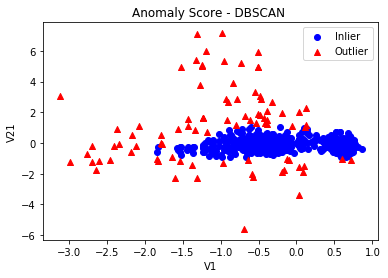

In [13]:
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

core_samples.shape

# Let's plot the data now
x = dataDBScan['V1']
y = dataDBScan['V21']

plt.scatter(x[core_samples],y[core_samples],marker='o',c='b',label='Inlier')
plt.scatter(x[~core_samples],y[~core_samples],marker='^',c='r',label='Outlier')
plt.xlabel("V1")
plt.ylabel("V21")
plt.title('Anomaly Score - DBSCAN ')
plt.legend()
plt.show()



## PCA Based Approaches

In all of the above mutil variate models we were using only 2 dimensions among the n-dimentional vector for the purpose of visual interpreration. Another approach to achieve the same thing would be to use PCA as a dimentionality reduction technique and viewing the first 2 principal components

In [14]:
# 30 principal components
from sklearn.decomposition import PCA

n_components = 2
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

dataX_PCA = pca.fit_transform(dataX)
dataX_PCA = pd.DataFrame(data=dataX_PCA, index=dataX.index)

In [15]:
# Percentage of Variance Captured by 784 principal components
print("Variance Explained by all principal components: ", \
      sum(pca.explained_variance_ratio_))



Variance Explained by all principal components:  0.12138147458344134


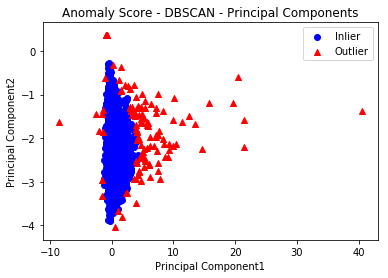

In [16]:
from sklearn.cluster import DBSCAN

dataX_PCA = dataX_PCA.loc[:10000]
#dataDBScan = dataX.loc[:1000]
dbsc = DBSCAN(eps = .5, min_samples = 15).fit(dataX_PCA[[0,1]])

labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

core_samples.shape

# Let's plot the data now
x = dataX_PCA[0]
y = dataX_PCA[1]

plt.scatter(x[core_samples],y[core_samples],marker='o',c='b',label='Inlier')
plt.scatter(x[~core_samples],y[~core_samples],marker='^',c='r',label='Outlier')
plt.title('Anomaly Score - DBSCAN - Principal Components')
plt.xlabel("Principal Component1")
plt.ylabel("Principal Component2")
plt.legend()
plt.show()


## PCA for Anomaly Detection

In [17]:
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)
    
# 27 principal components
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

#scatterPlot(X_train_PCA, y_train, "PCA")

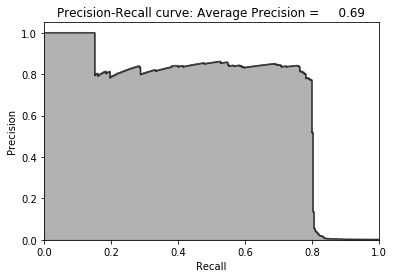

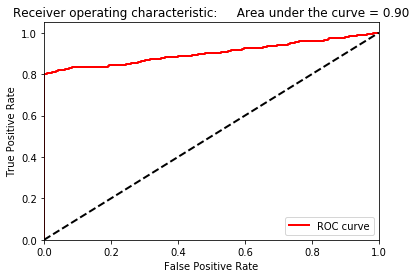

In [18]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [28]:
preds = pd.concat([y_train, anomalyScoresPCA], axis=1)
preds.columns = ['trueLabel', 'anomalyScore']

precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    
average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
        

preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Cases Caught:", predsTop.trueLabel.sum())


Precision:  0.75
Recall:  0.8
Fraud Cases Caught: 264


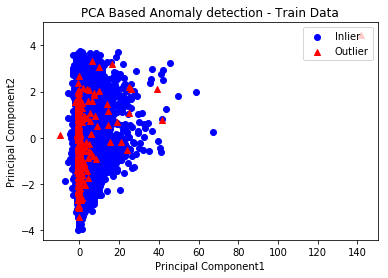

In [29]:
# Let's plot the data now
x = X_train_PCA[0]
y = X_train_PCA[1]

plt.scatter(x[preds['anomalyScore']<= 0.02],y[preds['anomalyScore']<= 0.02],marker='o',c='b',label='Inlier')
plt.scatter(x[preds['anomalyScore']> 0.02],y[preds['anomalyScore']> 0.02],marker='^',c='r',label='Outlier')

plt.xlabel("Principal Component1")
plt.ylabel("Principal Component2")
plt.title('PCA Based Anomaly detection - Train Data')
plt.legend(loc='upper right')
plt.show()

In [31]:
# PCA on Test Set
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)
X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, \
                                  index=X_test.index)

#scatterPlot(X_test_PCA, y_test, "PCA")

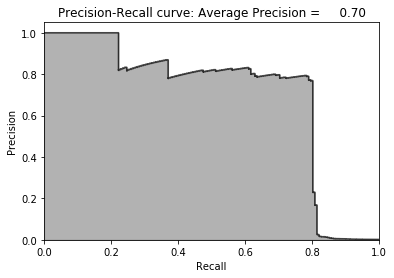

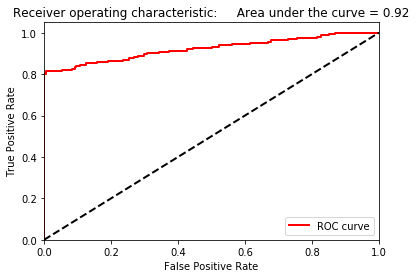

Precision:  0.82
Recall:  0.61
Fraud Caught Cases: 99


In [32]:
anomalyScorestestPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScorestestPCA, True)

preds = pd.concat([y_test, anomalyScorestestPCA], axis=1)
preds.columns = ['trueLabel', 'anomalyScorestestPCA']

precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScorestestPCA'])
    
average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScorestestPCA'])
        


preds.sort_values(by="anomalyScorestestPCA",ascending=False,inplace=True)
cutoff = 120
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScorestestPCA[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScorestestPCA[predsTop.trueLabel==1].count()/y_test.sum(),2))
print("Fraud Caught Cases:", predsTop.trueLabel.sum())



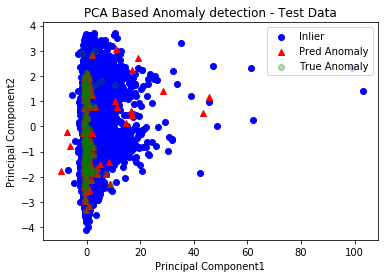

In [33]:
# Let's plot the data now
x = X_test_PCA[0]
y = X_test_PCA[1]
plt.scatter(x[preds['anomalyScorestestPCA']<= 0.02],y[preds['anomalyScorestestPCA']<= 0.02],marker='o',c='b',label='Inlier')
plt.scatter(x[preds['anomalyScorestestPCA']> 0.02],y[preds['anomalyScorestestPCA']> 0.02],marker='^',c='r',label= 'Pred Anomaly')
plt.scatter(x[y_test == 1],y[y_test == 1],alpha=0.3,marker='o',c='g',label = 'True Anomaly')
plt.legend(loc='upper right')
plt.title('PCA Based Anomaly detection - Test Data')
plt.xlabel("Principal Component1")
plt.ylabel("Principal Component2")
plt.show()

## PyOD Python Library

In [34]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats

In [71]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.003
# Define seven outlier detection tools to be compared
classifiers = {
        #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        #'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        #'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        #'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        #'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        #'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

C:\Program Files\Anaconda3\envs\unsupervisedLearning\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Program Files\Anaconda3\envs\unsupervisedLearning\lib\site-packages\pandas\core\frame.py:3144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Program Files\Anaconda3\envs\unsupervisedLearning\lib\site-packages\pandas\core\frame.py:3116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

OUTLIERS :  440 INLIERS :  190380 Histogram-base Outlier Detection (HBOS)
print(threshold) -3.7693029327390226


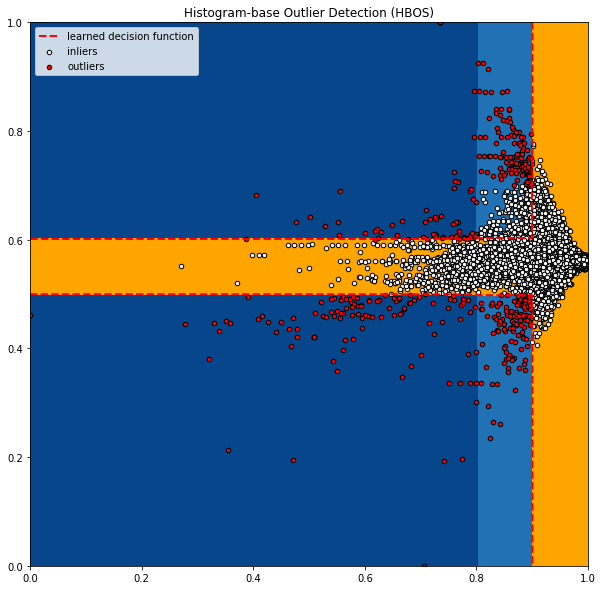

C:\Program Files\Anaconda3\envs\unsupervisedLearning\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Program Files\Anaconda3\envs\unsupervisedLearning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


OUTLIERS :  573 INLIERS :  190247 Isolation Forest
print(threshold) -0.2289967818298394


C:\Program Files\Anaconda3\envs\unsupervisedLearning\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\envs\unsupervisedLearning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ValueError: Number of features of the model must match the input. Model n_features is 3 and input n_features is 2.

<Figure size 720x720 with 0 Axes>

In [74]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))
cols = ['V1','V21']
X_train_pyod = X_train[cols]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_pyod[cols] = scaler.fit_transform(X_train_pyod)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train_pyod)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train_pyod) * -1
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train_pyod)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = X_train_pyod
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(X_train_pyod['V1'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(X_train_pyod['V21'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  X_train_pyod['V1'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  X_train_pyod['V21'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    print("print(threshold)",threshold)
    
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), -threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='red',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        #prop=plt.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

In [ ]:
preds = pd.concat([y_train, dfx['outlier']], axis=1)
preds.columns = ['trueLabel', 'anomalyScore']

precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    
average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
        
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 330
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Cases Caught:", predsTop.trueLabel.sum())


In [ ]:
# Let's plot the data now
plt.scatter(dfx.loc[dfx['outlier'] ==0,'V1'],dfx.loc[dfx['outlier'] ==0,'V21'],marker='o',c='b',label='Inlier')
plt.scatter(dfx.loc[dfx['outlier'] ==1,'V1'],dfx.loc[dfx['outlier'] ==1,'V21'],marker='^',c='r',label='Pred Anomaly')
plt.scatter(dfx.loc[y_train ==1,'V1'],dfx.loc[y_train ==1,'V21'],alpha=0.3,marker='^',c='g',label = 'True Anomaly')
plt.title('Anomaly Detection - HBOS Based')
plt.xlabel("V1")
plt.ylabel("V21")
plt.legend()
plt.show()